In [19]:
import math
from tqdm import tqdm
import torch
from torch import Tensor, nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

from typing import Union, Tuple, List, Optional, Callable, Any
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader

import sys
from pathlib import Path
# Go up one level from training_scripts/ to the project root
project_root = Path().resolve().parent
sys.path.append(str(project_root))

%load_ext autoreload
%autoreload 2

from smc.smc import sequential_monte_carlo
from smc.sampling_algorithms import (
    systematic_resample,
    stratified_resample,
    multinomial_resample
)
from smc.utils import lambda_schedule
from datasets import checkerboard

from smc_scripts.plot_utils import plot_smc_results_binarized_mnist

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import torch
import random
import torch.backends.cudnn as cudnn

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


## Load pre-trained mdm model

In [20]:

from models.discrete_diffusion.mdm import MaskedDiffusion
from models.discrete_diffusion.utils.parametrizations import (
    subs_parametrization,
    subs_parametrization_continuous,
)
from models.denoising_models.mlp import MLP
from models.denoising_models.unet_with_attention import UNetWithAttention

batch_size = 64
vocab_size = 2
num_categories = vocab_size + 1  #includes the mask category
mask_index = num_categories - 1
input_shape = (1, 28, 28)
num_timesteps = 1000

pretrained_model = MaskedDiffusion(
    denoising_model=UNetWithAttention(
        num_categories=num_categories,
        embedding_dim=64,
        ch_mult=(2, 4, 8),
        num_res_blocks=2,
        attention_resolutions=(1, 2),
        encode_time=False,
        probs_parametrization_fn=subs_parametrization,
    ),
    num_categories=num_categories,
    input_shape=input_shape,
    mask_index=mask_index,
    masking_schedule="linear",
    num_timesteps=num_timesteps,
    discretization_schedule="cosine",
).to(device)

# load model weights
pretrained_model.load_state_dict(torch.load('../model_weights/mdm_binarized_mnist_256.pth'))

pretrained_model_with_subs_continuous = MaskedDiffusion(
    denoising_model=UNetWithAttention(
        num_categories=num_categories,
        embedding_dim=64,
        ch_mult=(2, 4, 8),
        num_res_blocks=2,
        attention_resolutions=(1, 2),
        encode_time=False,
        probs_parametrization_fn=subs_parametrization_continuous,
    ),
    num_categories=num_categories,
    input_shape=input_shape,
    mask_index=mask_index,
    masking_schedule="linear",
    num_timesteps=num_timesteps,
    discretization_schedule="cosine",
).to(device)

# load model weights
pretrained_model_with_subs_continuous.load_state_dict(torch.load('../model_weights/mdm_binarized_mnist_256.pth'))

<All keys matched successfully>

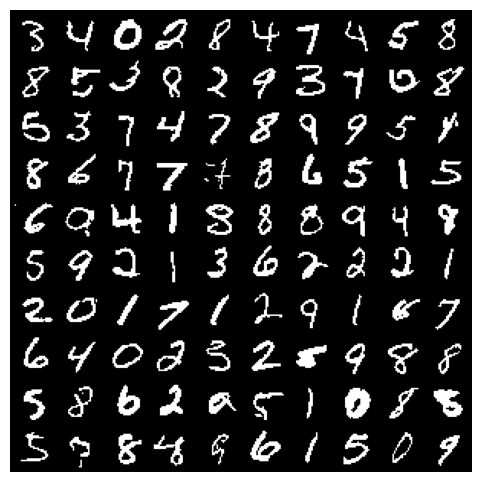

In [21]:
# Visualize samples
pretrained_model.eval()
with torch.no_grad():
    samples = pretrained_model.sample(num_samples=100, device=device).float().cpu()
grid = utils.make_grid(samples, nrow=10, padding=2)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0).squeeze().cpu().numpy(), cmap="gray")
plt.axis('off')
plt.show()

## Define Reward, KL penalty coefficient, and Corresponding Target Distribution

In [38]:
from models.reward_models.binarized_mnist_classifier import BinarizedMNISTClassifier
import torch
mnist_classfier_model = BinarizedMNISTClassifier().to(device)
mnist_classfier_model.load_state_dict(torch.load('../model_weights/binarized_mnist_classifier.pth'))

def compute_rewards_for_batch(x: Tensor, with_grad=False):
    # x.shape : (B, 1, 28, 28, num_categories)
    logits = mnist_classfier_model(x[..., :vocab_size].to(device)) # Shape: (B, 10)
    logits = logits.log_softmax(dim=-1) # Shape: (B, 10)
    # probs = logits.softmax(dim=-1) # Shape: (B, 10)
    # reward = probs[:, 9]
    reward = logits[:, 9]
    return reward

def compute_rewards(x, with_grad=False):
    n_samples = x.shape[0]
    rewards_all = []
    for i in range(0, n_samples, batch_size):
        if with_grad:
            rewards = compute_rewards_for_batch(x[i:i + batch_size])
        else:
            with torch.no_grad():
                rewards = compute_rewards_for_batch(x[i:i + batch_size])
        rewards_all.append(rewards)
    rewards_all = torch.cat(rewards_all)
    return rewards_all

kl_weight = 1

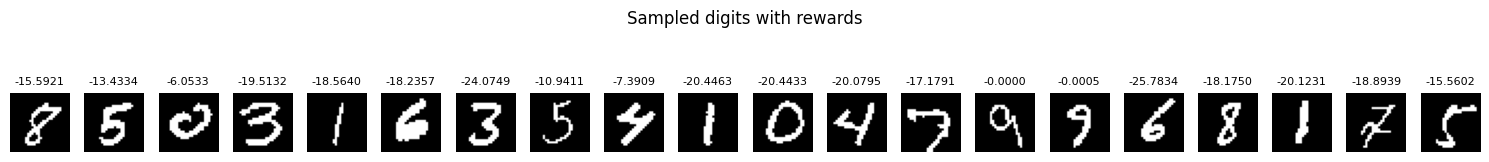

In [33]:
# Visualize rewards
from datasets.binarized_mnist import build_dataloaders
train_loader, test_loader = build_dataloaders(batch_size=20)
samples, _ = next(iter(train_loader))
rewards = compute_rewards(F.one_hot(samples.long(), num_classes=num_categories).float())

fig, axes = plt.subplots(1, 20, figsize=(15, 2))
for i in range(20):
    ax = axes[i]
    ax.imshow(samples[i].squeeze().cpu().numpy(), cmap="gray")
    ax.set_title(f"{rewards[i].item():.4f}", fontsize=8)
    ax.axis("off")

plt.suptitle("Sampled digits with rewards", fontsize=12)
plt.tight_layout()
plt.show()

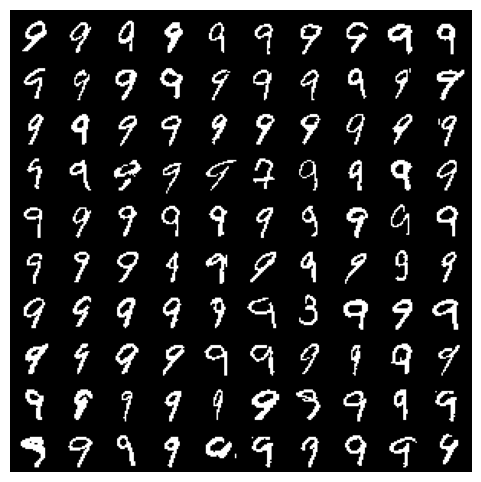

Target Reward: -0.11186763644218445
Diversity: 99


In [39]:
from datasets.binarized_mnist import build_dataloaders

def target_distribution_log_pdf(x, kl_weight):
    reward = compute_rewards(F.one_hot(x, num_classes=num_categories).float())
    return reward / kl_weight

def sample_target_distribution(n_samples, kl_weight):
    train_loader, test_loader = build_dataloaders(batch_size=batch_size, shuffle_train=False)
    log_pdf_values = []
    for samples, _ in train_loader:
        samples = samples.long()
        log_pdf_values.append(target_distribution_log_pdf(samples, kl_weight))
    log_pdf_values = torch.cat(log_pdf_values, dim=0)
    indices = torch.distributions.Categorical(logits=log_pdf_values).sample((n_samples,))
    return torch.stack([train_loader.dataset[i][0].long() for i in indices])

target_samples = sample_target_distribution(100, kl_weight)

grid = utils.make_grid(target_samples, nrow=10, padding=2)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0).squeeze().float().cpu().numpy(), cmap="gray")
plt.axis('off')
plt.show()

target_rewards = compute_rewards(
    F.one_hot(target_samples, num_classes=num_categories).float()
)
print(f"Target Reward: {target_rewards.mean().item()}")
print(f"Diversity: {torch.unique(target_samples, dim=0).shape[0]}")

In [60]:
def intialize_particles(num_particles, device=device):
    particles = torch.full((num_particles, *input_shape), mask_index, device=device, requires_grad=False)
    return particles

## Reverse diffusion as proposal

In [61]:
def reverse_as_proposal(X_t, x_s_probs, t, lambdas, kl_weight, rewards_grad, model, reward_estimate_sample_count) -> tuple[Tensor, Tensor]:
    """
    Returns:
        tuple[Tensor, Tensor]: A tuple containing the proposed samples and their log probabilities.
    """
    # 1. Define proposal distribution
    proposal_distribution = torch.distributions.Categorical(probs=x_s_probs)
    
    # 2. Sample new particles from the proposal
    X_s = proposal_distribution.sample()
    
    # 3. Calcualte log probabibility of the new particles under the proposal distribution
    log_prob_proposal = proposal_distribution.log_prob(X_s) # Shape: (N, L)
    log_prob_proposal = log_prob_proposal.sum(dim=-1) # Shape: (N)
        
    return X_s.reshape(X_t.shape), log_prob_proposal

In [62]:
num_particles = 20
lambdas = lambda_schedule(num_timesteps)

X_0, W_0, ess_trace, rewards_trace, particles_trace, log_weights_trace, resampling_trace = sequential_monte_carlo(
    model=pretrained_model,
    num_categories=num_categories,
    T=num_timesteps,
    N=num_particles,
    ESS_min=num_particles / 2,
    intialize_particles_fn=intialize_particles,
    resample_fn=systematic_resample,
    proposal_fn=reverse_as_proposal,
    compute_reward_fn=compute_rewards,
    lambdas=lambdas,
    kl_weight=kl_weight,
    reward_estimate_sample_count=3,
    device=device,
    verbose=False,
)

100%|██████████| 1000/1000 [01:01<00:00, 16.15it/s]

Resampled 5 times.


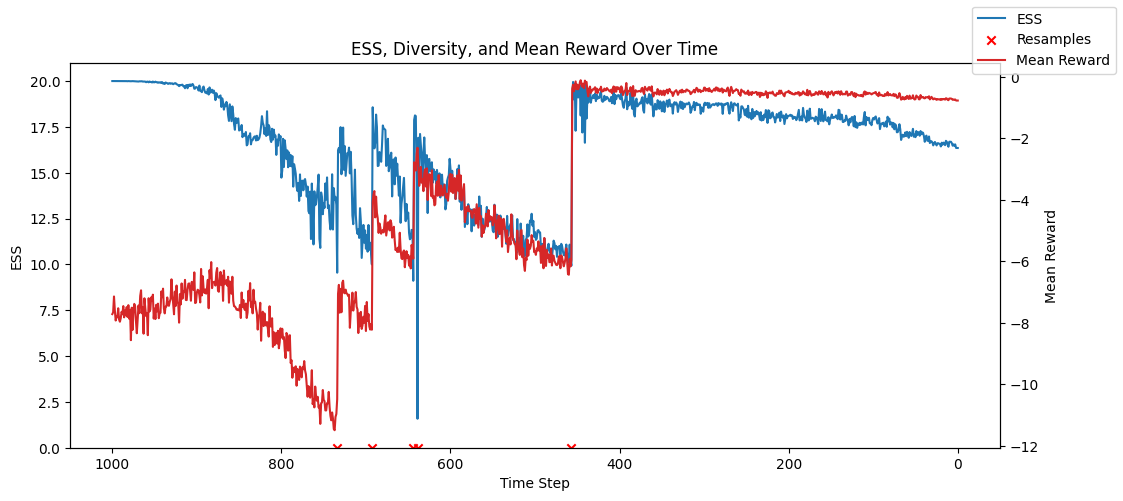

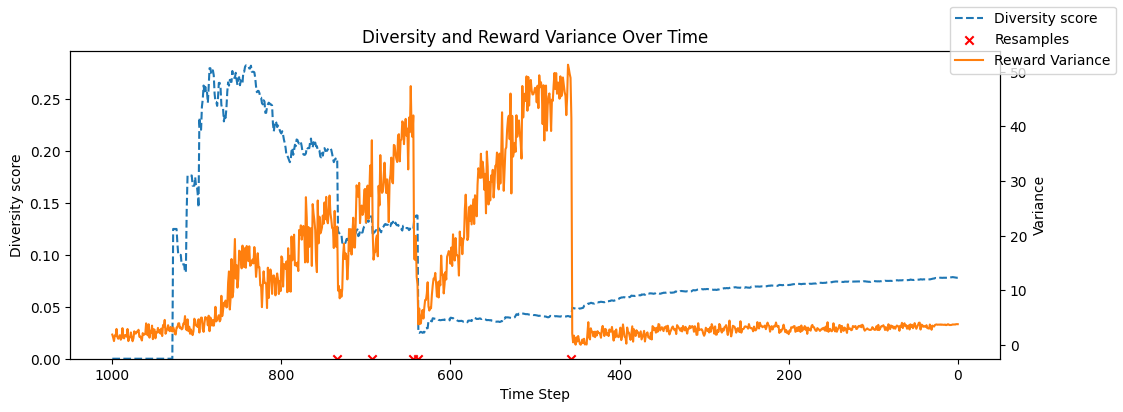

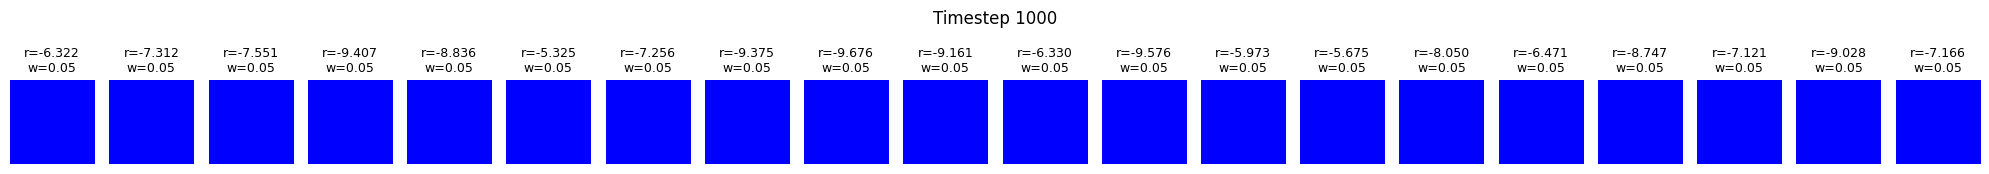

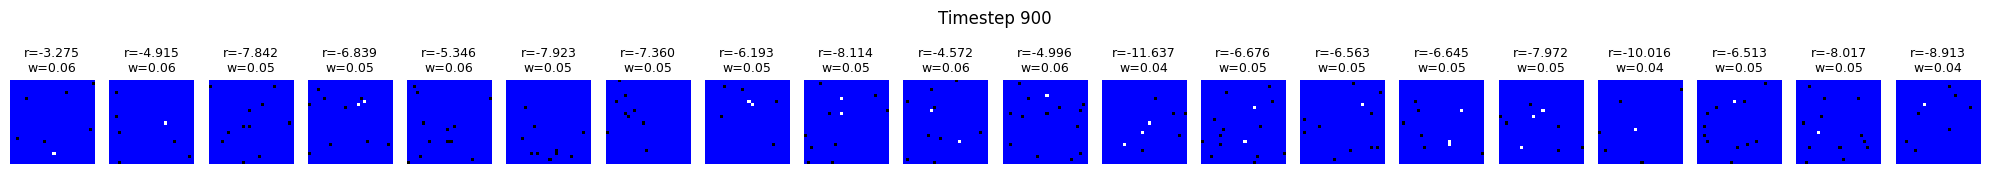

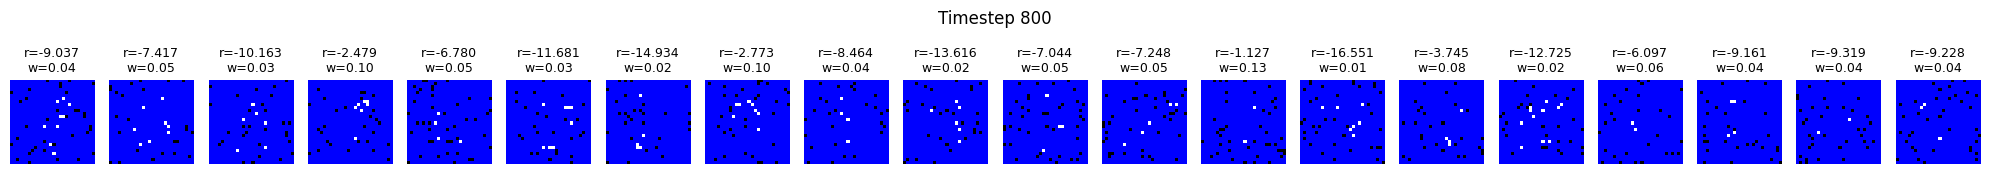

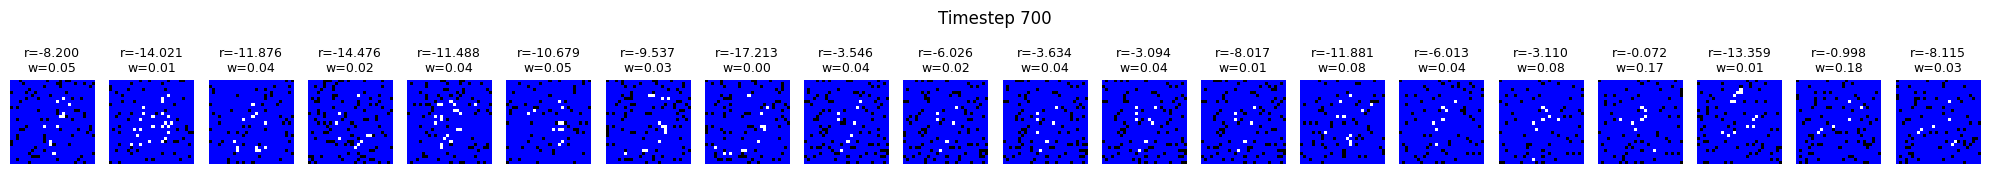

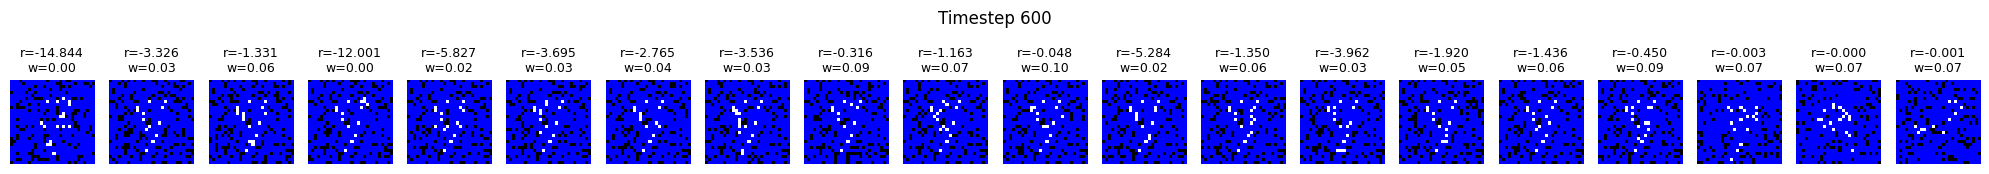

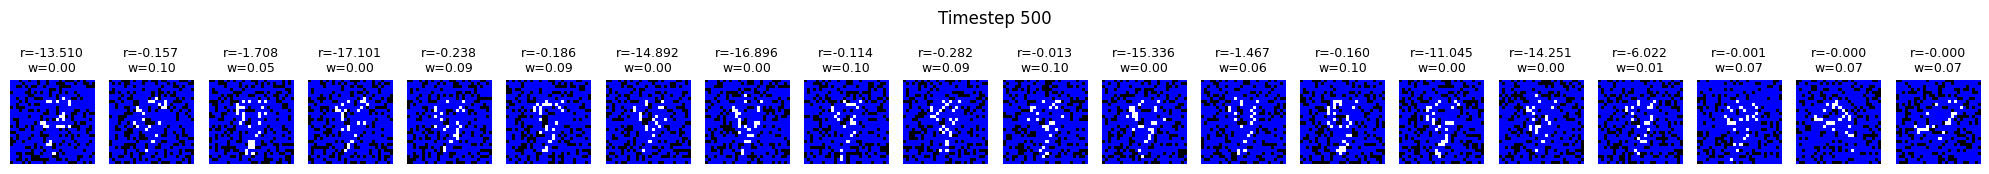

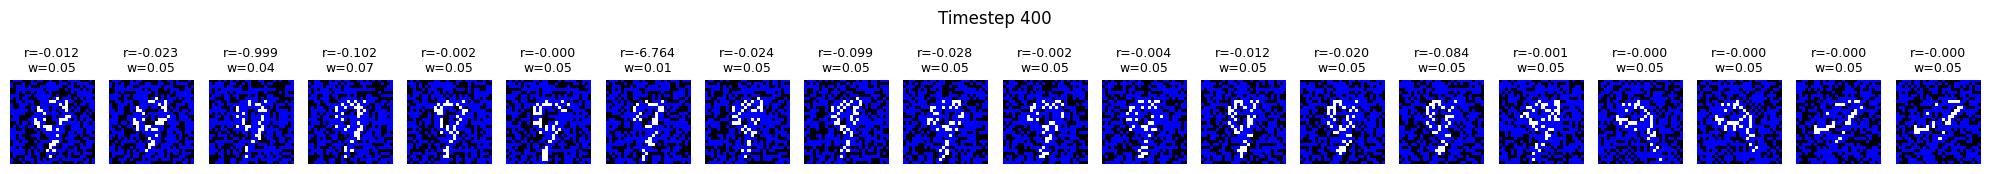

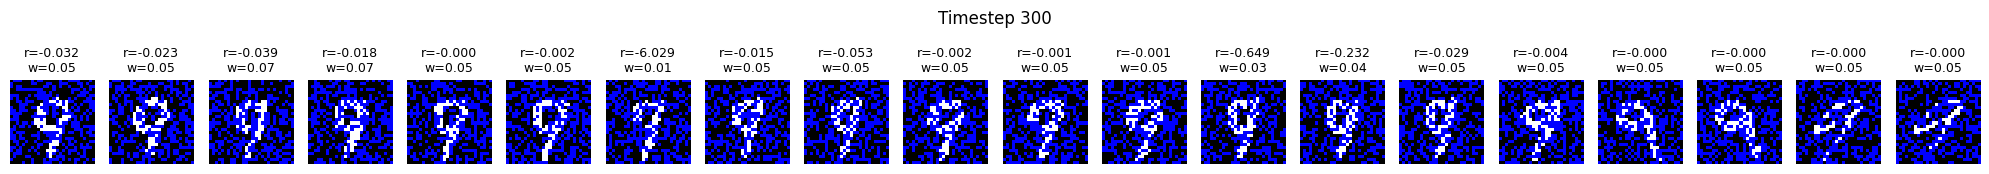

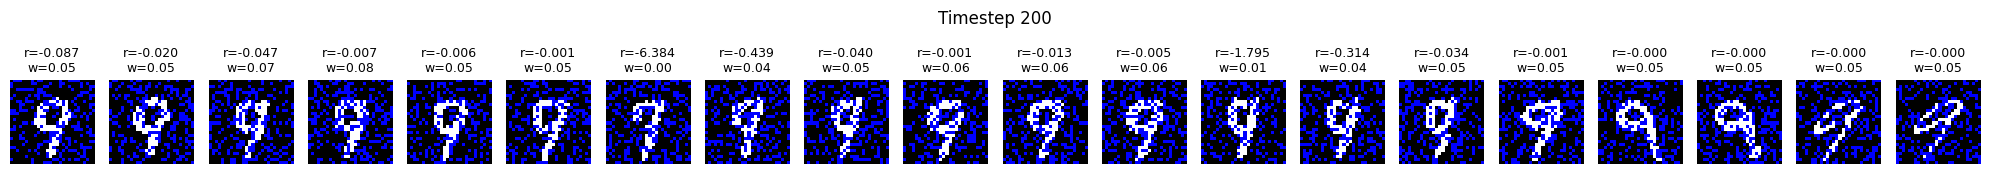

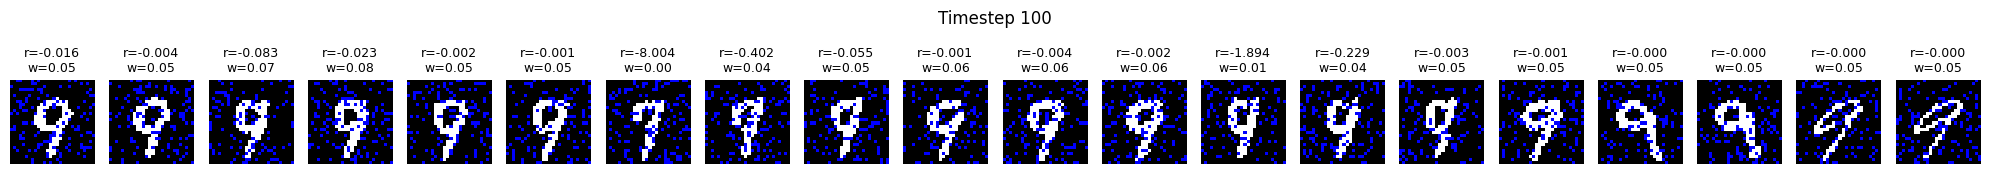

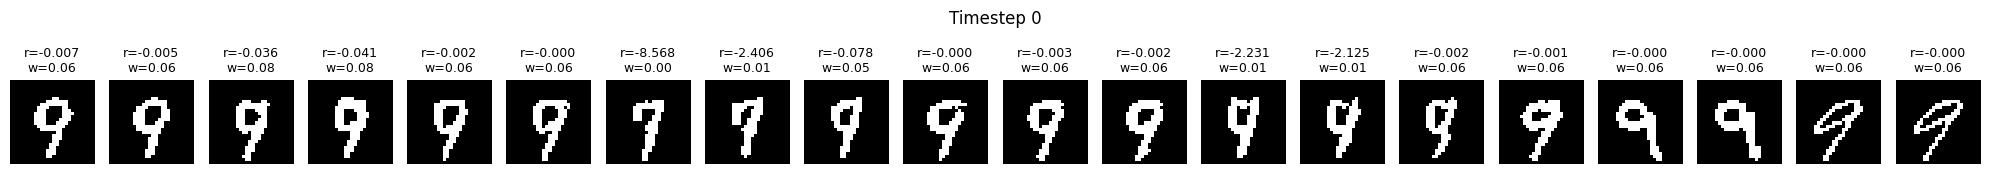

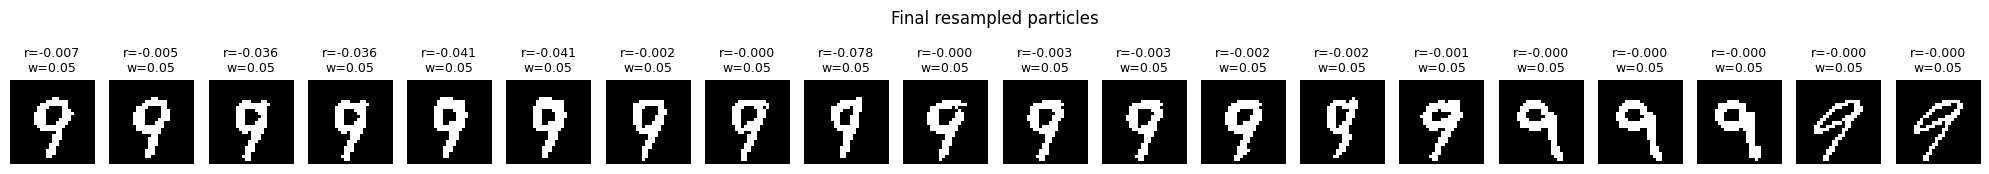

Final average reward: -0.0128
Final diversity score: 0.08188104189044036
Final uniqueness: 16


In [63]:
plot_smc_results_binarized_mnist(X_0, W_0, ess_trace, rewards_trace, particles_trace, log_weights_trace, resampling_trace, num_timesteps, vocab_size, num_categories, compute_rewards)

## First order approximate proposal

In [64]:
def first_order_approximation_optimal_proposal(X_t, x_s_probs, t, lambdas, kl_weight, rewards_grad, model, reward_estimate_sample_count) -> tuple[Tensor, Tensor]:
    logits_proposal = torch.log(x_s_probs) + (lambdas[t-1] / kl_weight) * rewards_grad # Shape: (N, L, C)
    
    # 1. Define proposal distribution
    proposal_distribution = torch.distributions.Categorical(logits=logits_proposal)
    
    # 2. Sample new particles from the proposal
    X_s = proposal_distribution.sample()
    
    # 3. Calcualte log probabibility of the new particles under the proposal distribution
    log_prob_proposal = proposal_distribution.log_prob(X_s) # Shape: (N, L)
    log_prob_proposal = log_prob_proposal.sum(dim=-1) # Shape: (N)
        
    return X_s.reshape(X_t.shape), log_prob_proposal

In [65]:
num_particles = 20
lambdas = lambda_schedule(num_timesteps)

X_0, W_0, ess_trace, rewards_trace, particles_trace, log_weights_trace, resampling_trace = sequential_monte_carlo(
    model=pretrained_model,
    num_categories=num_categories,
    T=num_timesteps,
    N=num_particles,
    ESS_min=num_particles / 2,
    intialize_particles_fn=intialize_particles,
    resample_fn=systematic_resample,
    proposal_fn=first_order_approximation_optimal_proposal,
    compute_reward_fn=compute_rewards,
    lambdas=lambdas,
    kl_weight=kl_weight,
    reward_estimate_sample_count=3,
    device=device,
    verbose=False,
)

100%|██████████| 1000/1000 [01:04<00:00, 15.52it/s]

Resampled 4 times.


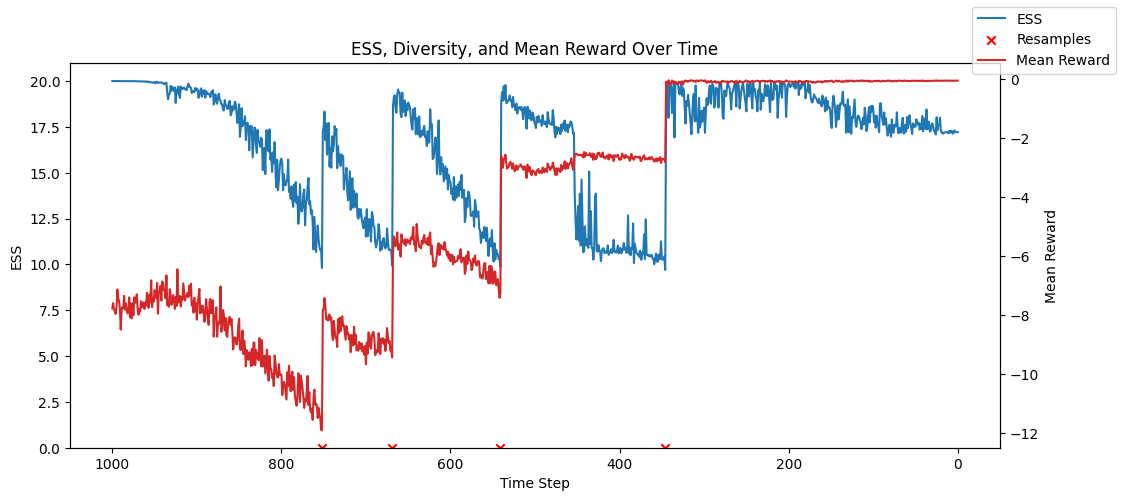

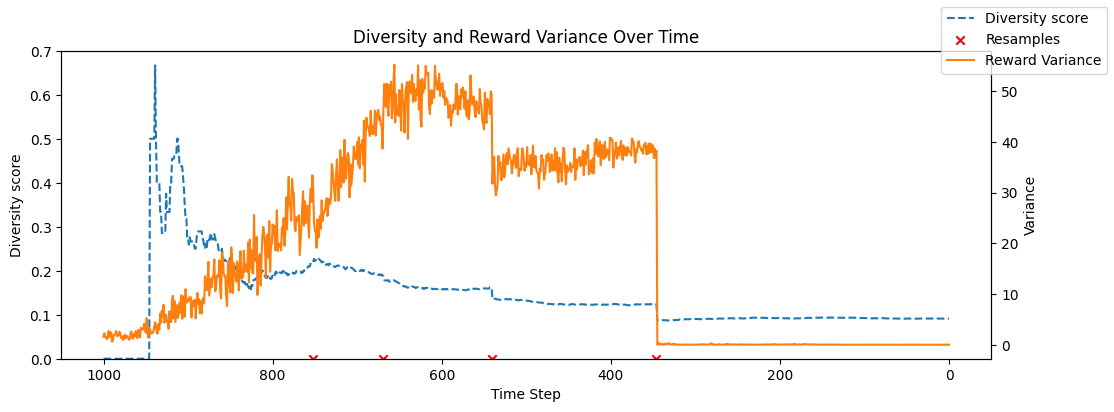

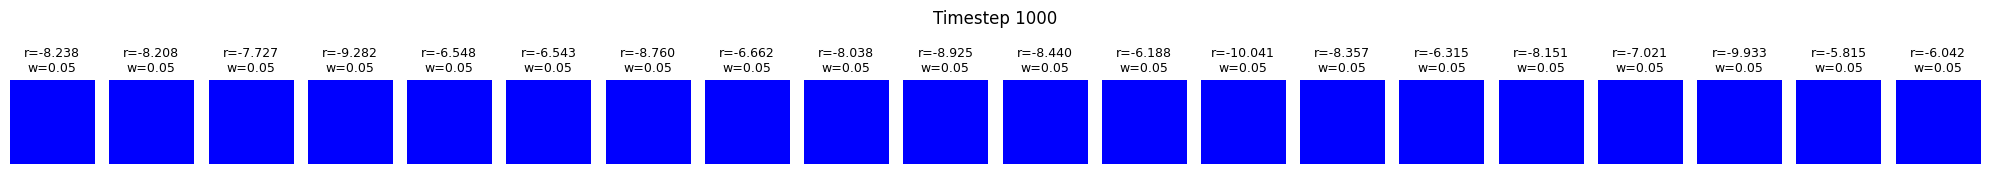

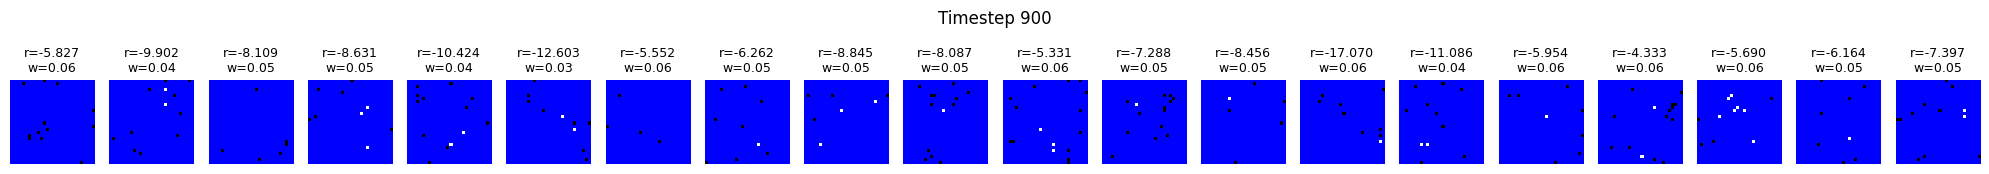

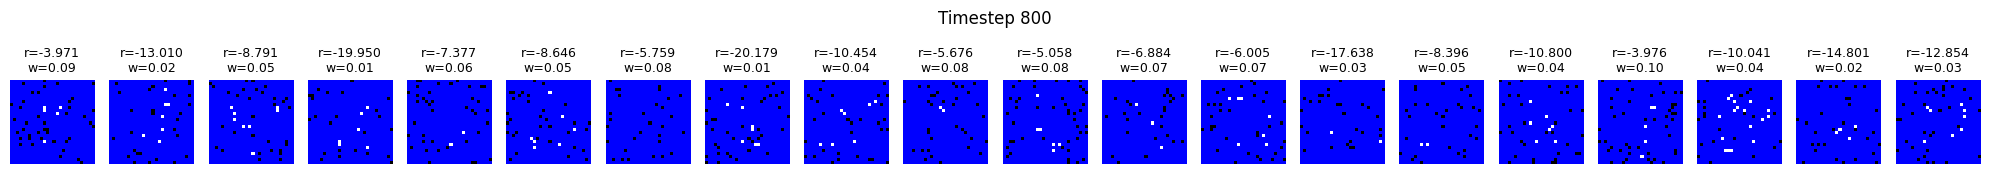

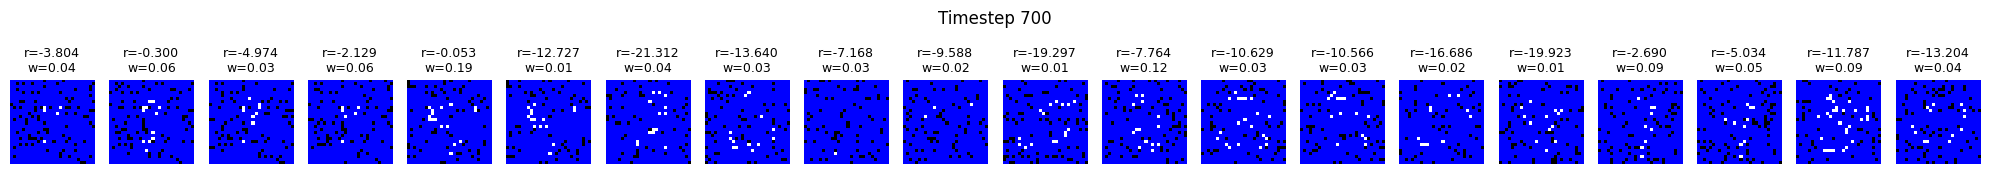

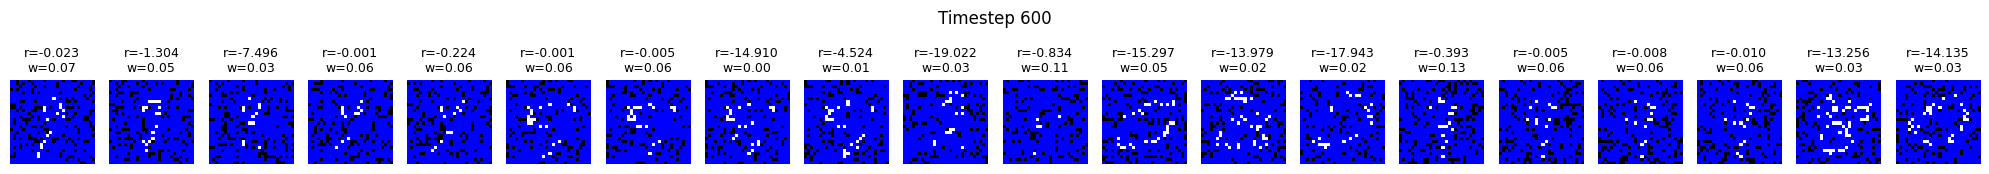

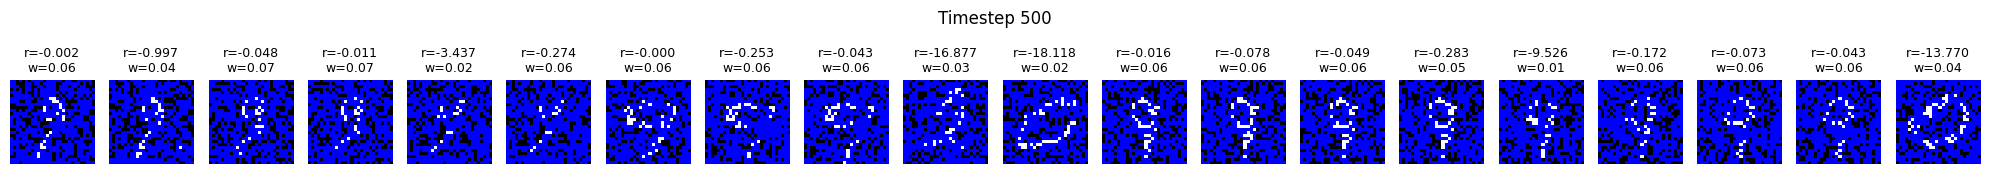

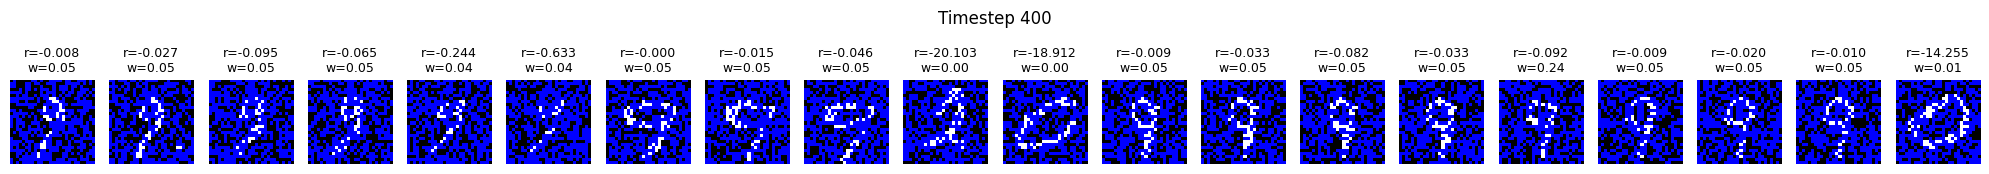

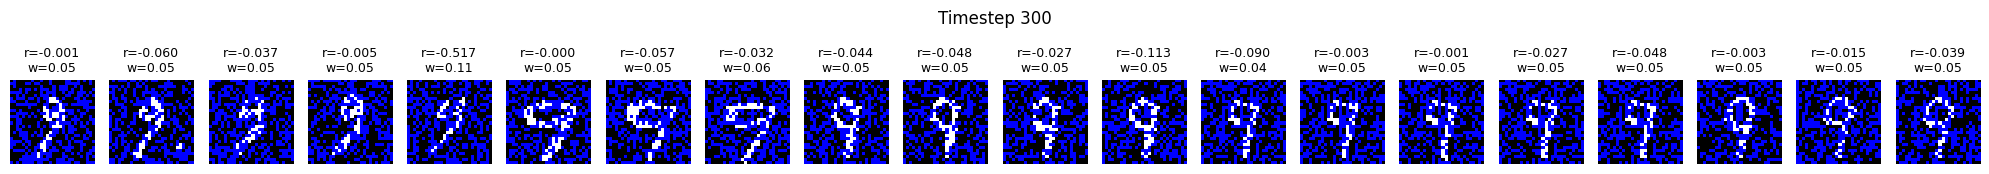

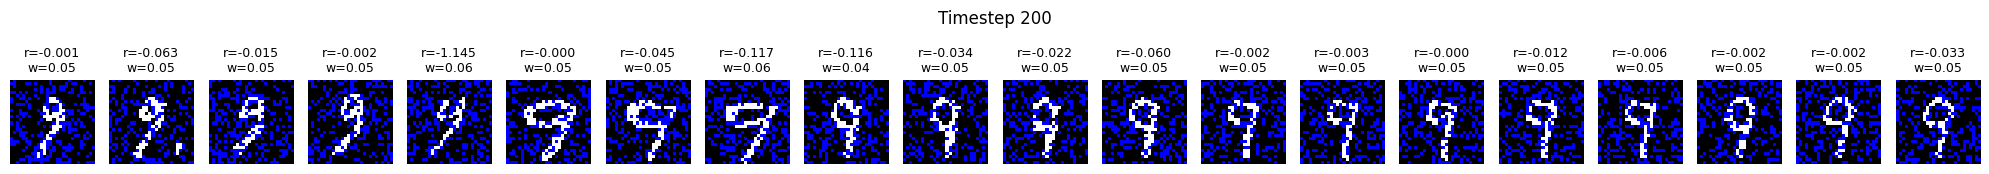

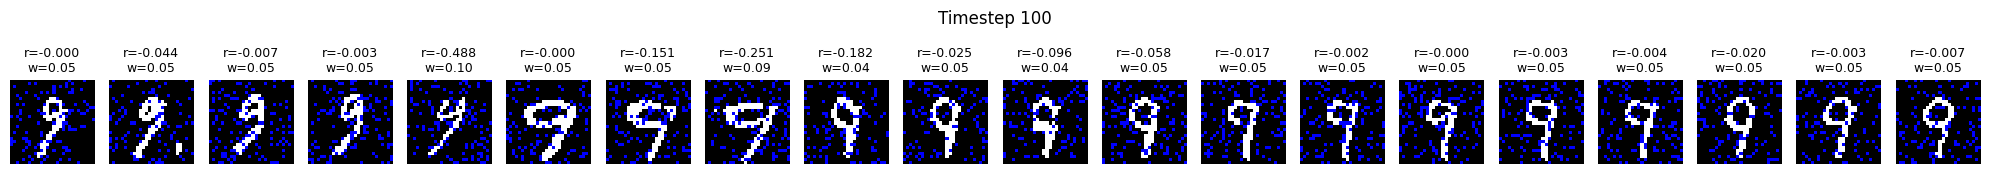

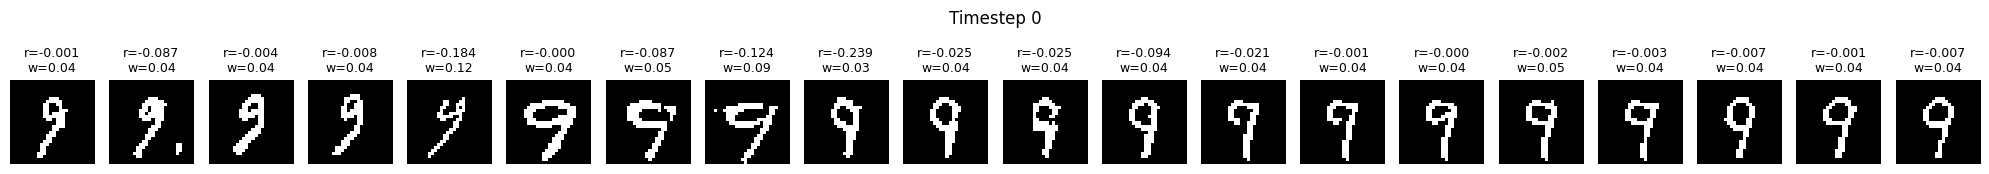

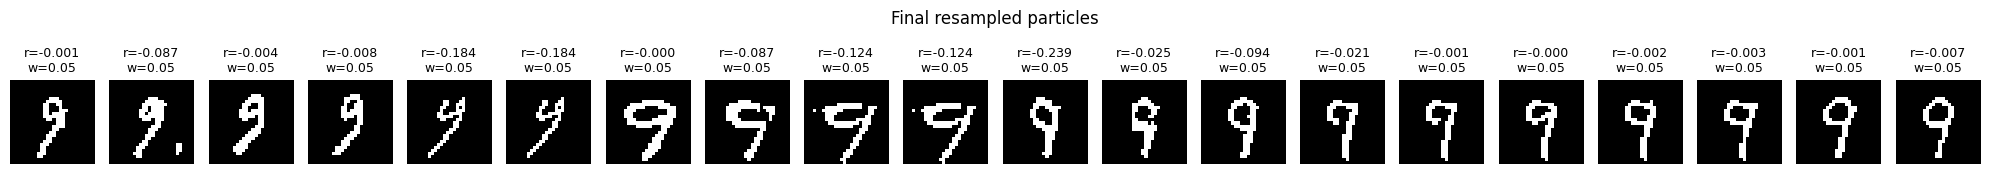

Final average reward: -0.0598
Final diversity score: 0.09885204081632655
Final uniqueness: 18


In [66]:
plot_smc_results_binarized_mnist(X_0, W_0, ess_trace, rewards_trace, particles_trace, log_weights_trace, resampling_trace, num_timesteps, vocab_size, num_categories, compute_rewards)

## First order approximate proposal with continuos formulation of subs parametrization

In [67]:
num_particles = 20
lambdas = lambda_schedule(num_timesteps)

X_0, W_0, ess_trace, rewards_trace, particles_trace, log_weights_trace, resampling_trace = sequential_monte_carlo(
    model=pretrained_model_with_subs_continuous,
    num_categories=num_categories,
    T=num_timesteps,
    N=num_particles,
    ESS_min=num_particles / 2,
    intialize_particles_fn=intialize_particles,
    resample_fn=systematic_resample,
    proposal_fn=first_order_approximation_optimal_proposal,
    compute_reward_fn=compute_rewards,
    lambdas=lambdas,
    kl_weight=kl_weight,
    reward_estimate_sample_count=3,
    device=device,
    verbose=False,
)

100%|██████████| 1000/1000 [01:05<00:00, 15.23it/s]

Resampled 8 times.


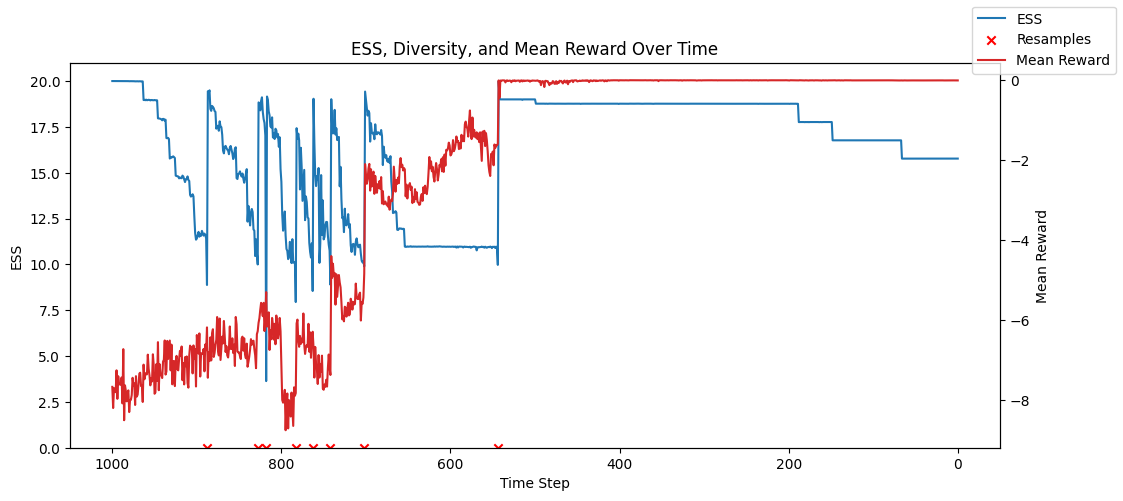

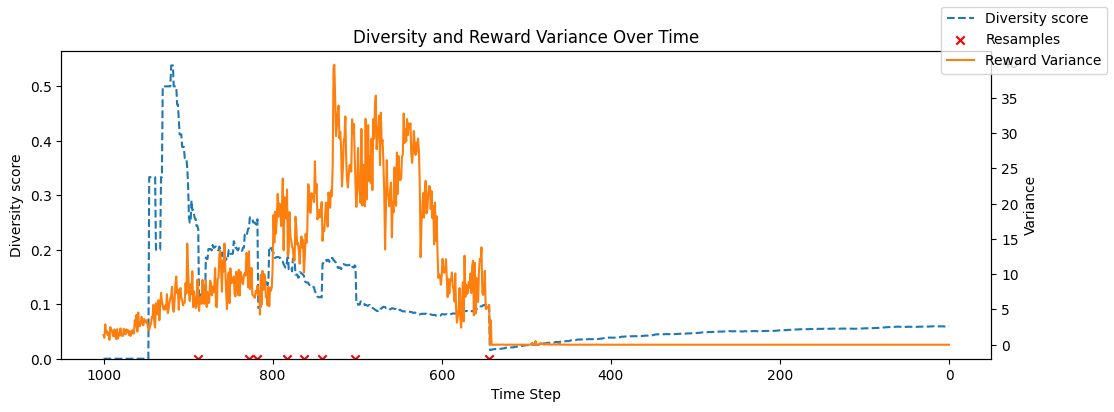

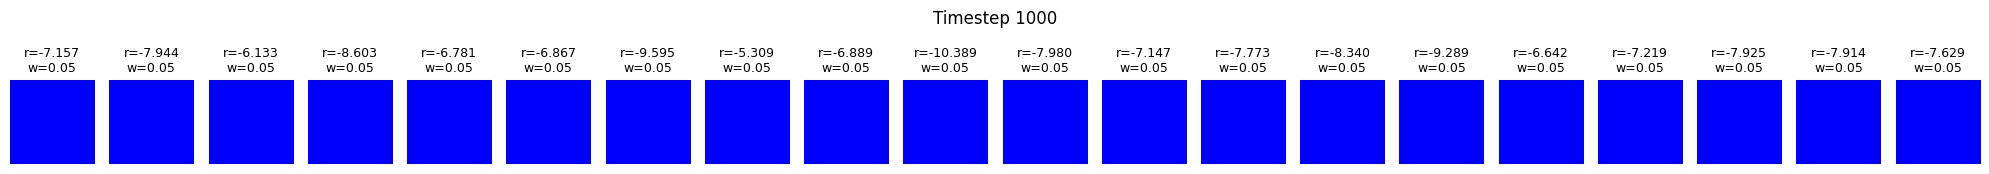

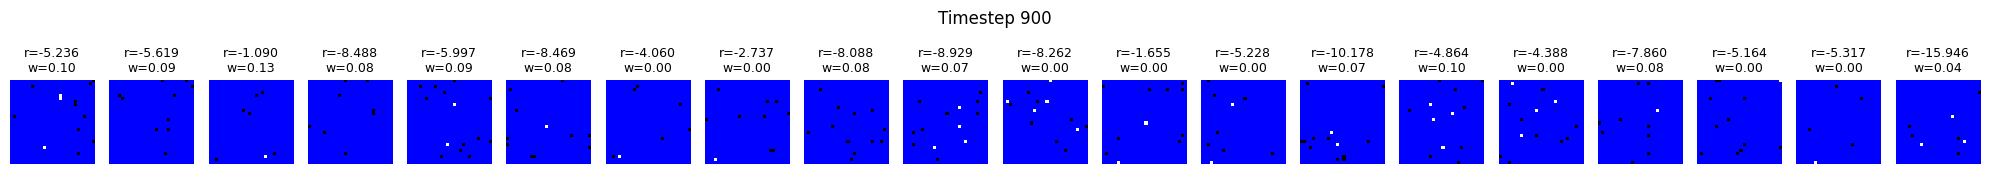

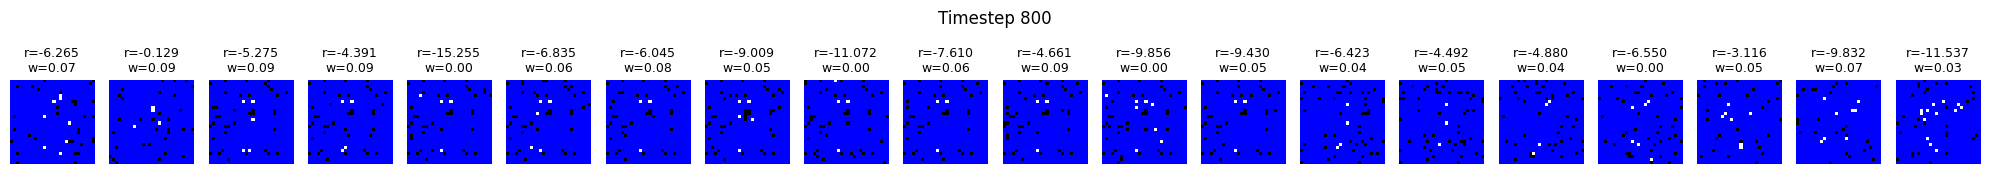

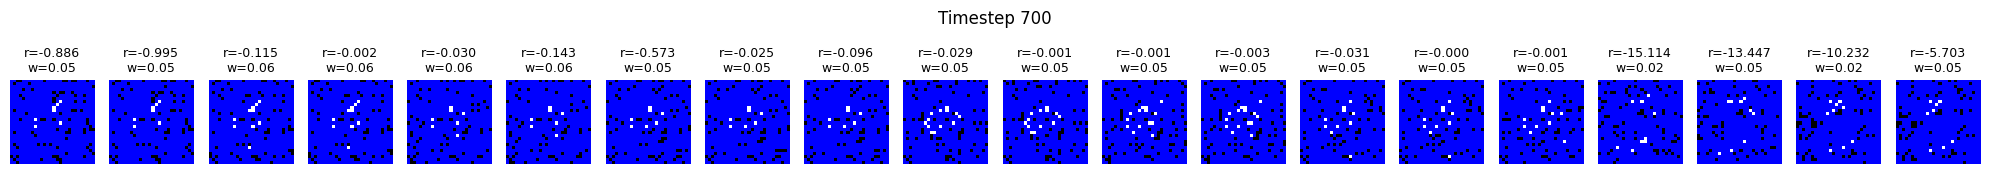

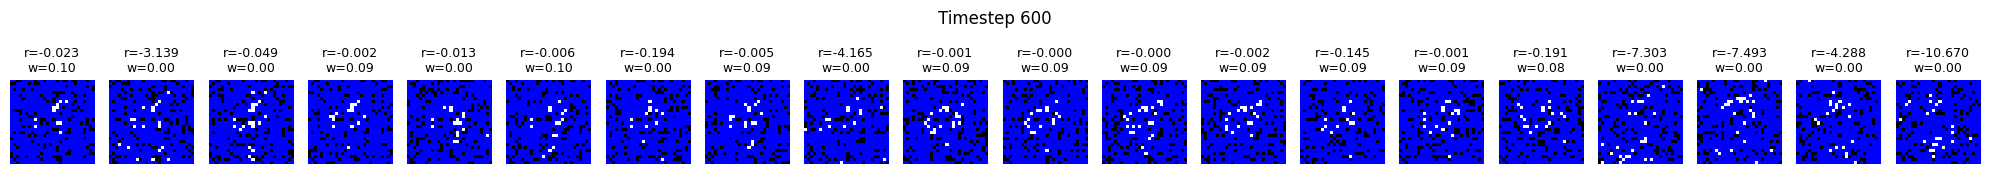

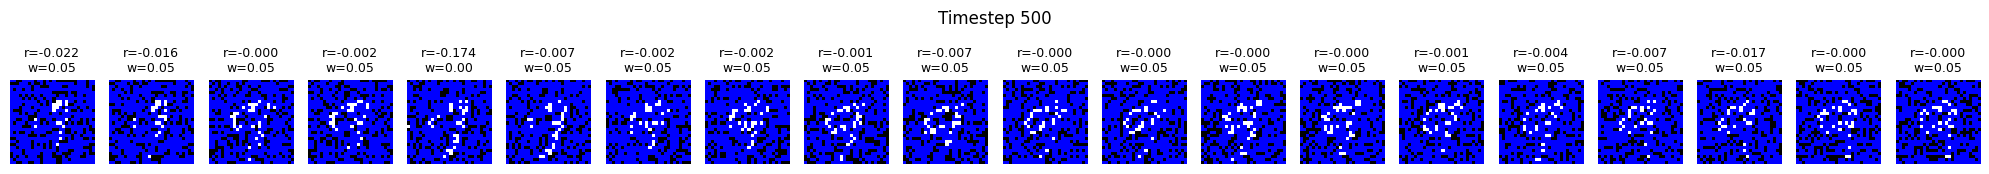

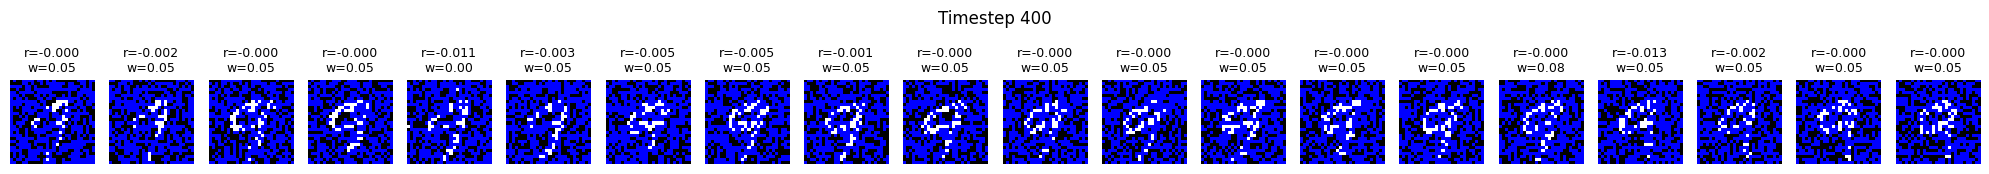

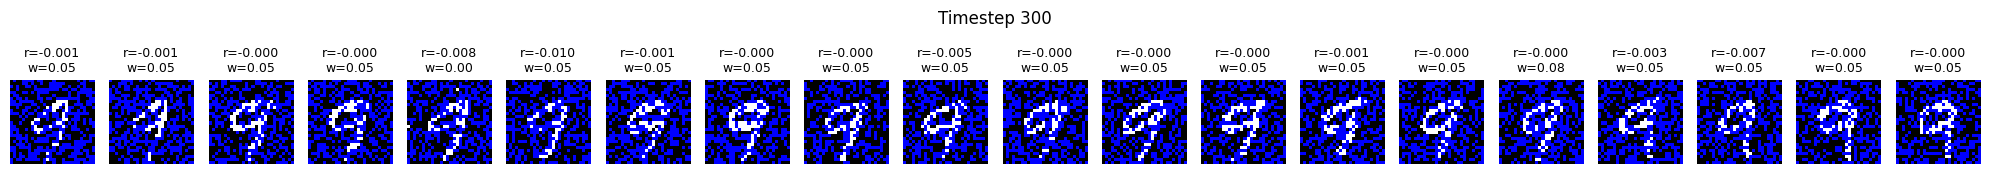

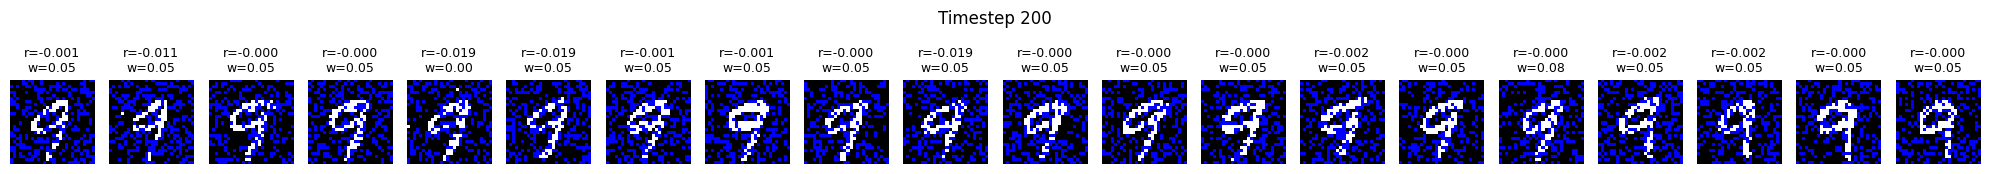

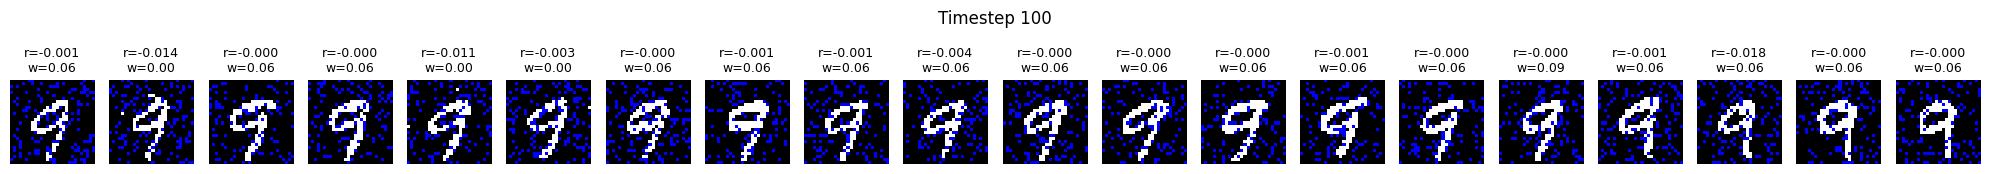

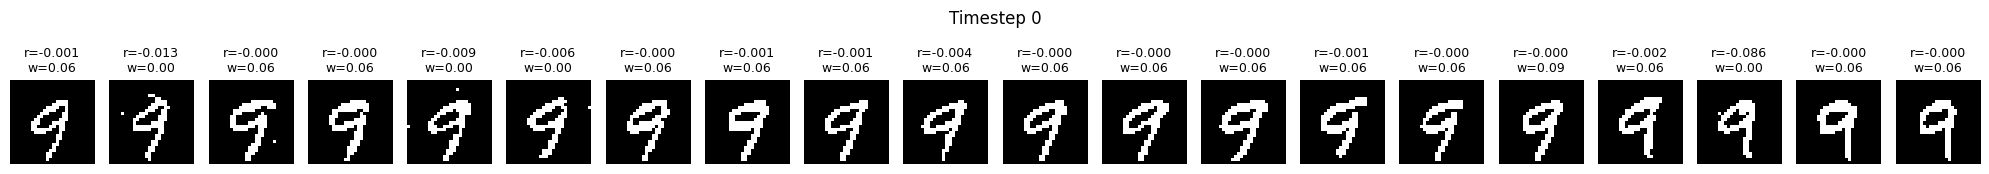

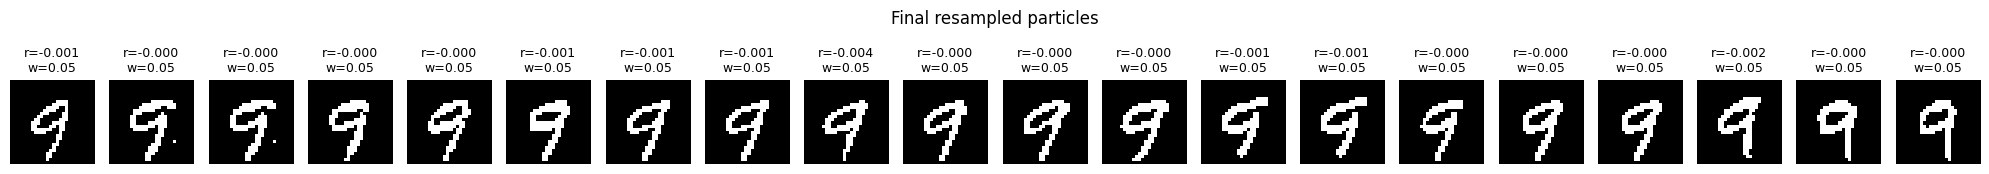

Final average reward: -0.0007
Final diversity score: 0.05497448979591836
Final uniqueness: 16


In [68]:
plot_smc_results_binarized_mnist(X_0, W_0, ess_trace, rewards_trace, particles_trace, log_weights_trace, resampling_trace, num_timesteps, vocab_size, num_categories, compute_rewards)

## First order approximate proposal with continuos formulation of subs parametrization and gradient clipping

In [69]:
def first_order_approximation_optimal_proposal_with_gradient_clipping(X_t, x_s_probs, t, lambdas, kl_weight, rewards_grad, model, reward_estimate_sample_count) -> tuple[Tensor, Tensor]:
    # normalize and clip gradients
    rewards_grad = rewards_grad - rewards_grad.mean(dim=-1, keepdim=True)
    rewards_grad = torch.clamp(rewards_grad, -10, 10)
    
    logits_proposal = torch.log(x_s_probs) + (lambdas[t-1] / kl_weight) * rewards_grad # Shape: (N, L, C)
    
    # 1. Define proposal distribution
    proposal_distribution = torch.distributions.Categorical(logits=logits_proposal)
    
    # 2. Sample new particles from the proposal
    X_s = proposal_distribution.sample()
    
    # 3. Calcualte log probabibility of the new particles under the proposal distribution
    log_prob_proposal = proposal_distribution.log_prob(X_s) # Shape: (N, L)
    log_prob_proposal = log_prob_proposal.sum(dim=-1) # Shape: (N)
        
    return X_s.reshape(X_t.shape), log_prob_proposal

In [70]:
num_particles = 20
lambdas = lambda_schedule(num_timesteps)

X_0, W_0, ess_trace, rewards_trace, particles_trace, log_weights_trace, resampling_trace = sequential_monte_carlo(
    model=pretrained_model_with_subs_continuous,
    num_categories=num_categories,
    T=num_timesteps,
    N=num_particles,
    ESS_min=num_particles / 2,
    intialize_particles_fn=intialize_particles,
    resample_fn=systematic_resample,
    proposal_fn=first_order_approximation_optimal_proposal_with_gradient_clipping,
    compute_reward_fn=compute_rewards,
    lambdas=lambdas,
    kl_weight=kl_weight,
    reward_estimate_sample_count=3,
    device=device,
    verbose=False,
)

100%|██████████| 1000/1000 [01:05<00:00, 15.18it/s]

Resampled 4 times.


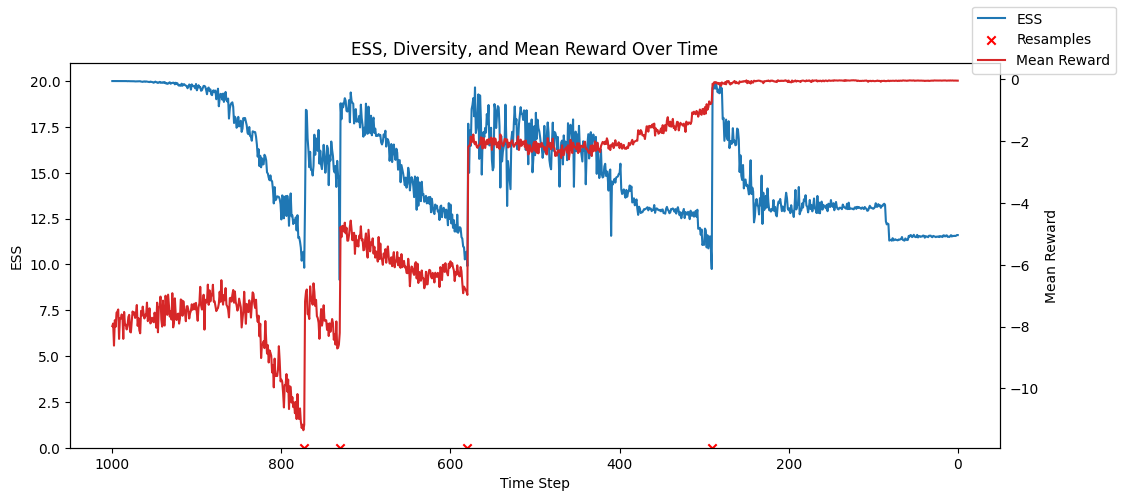

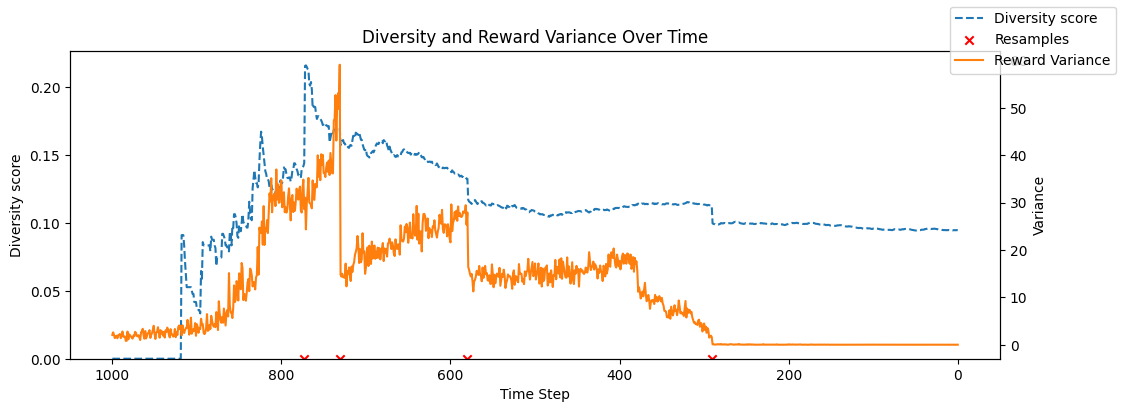

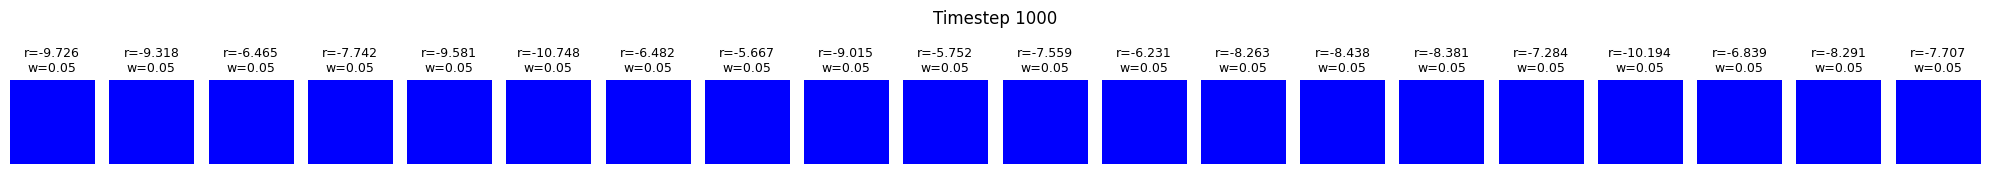

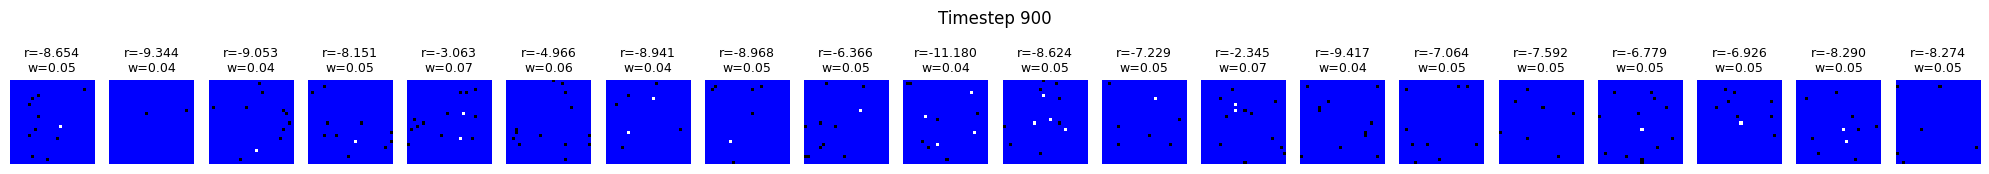

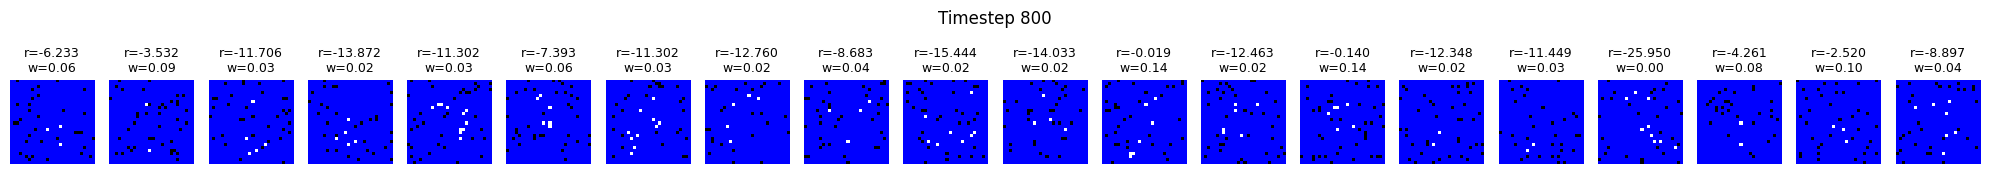

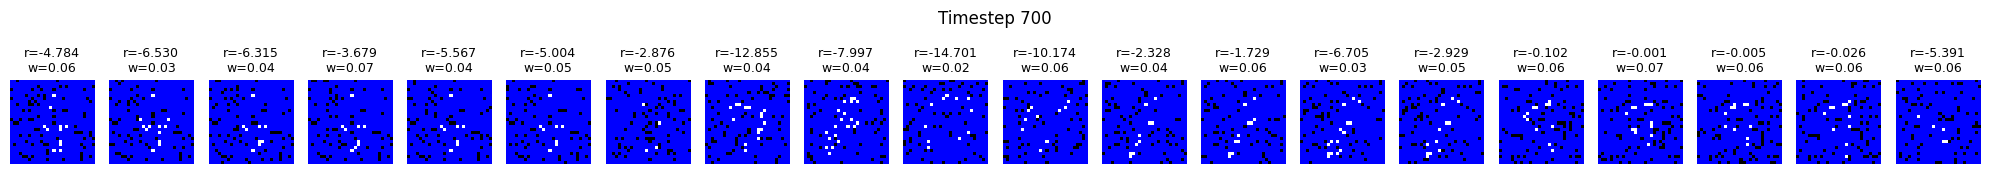

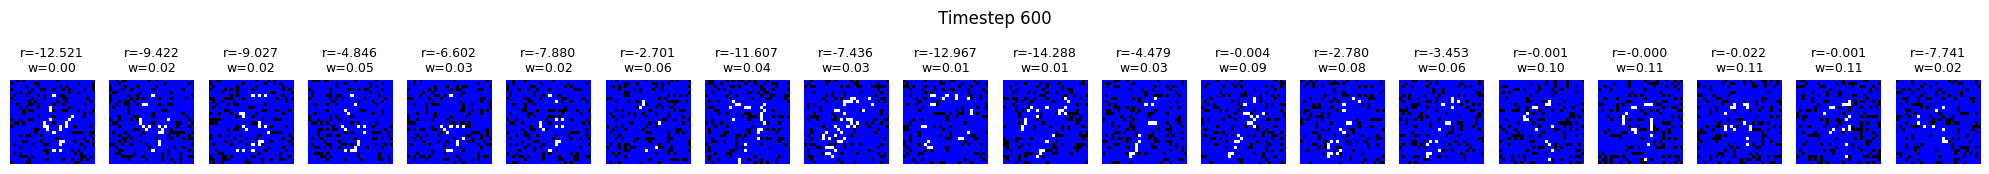

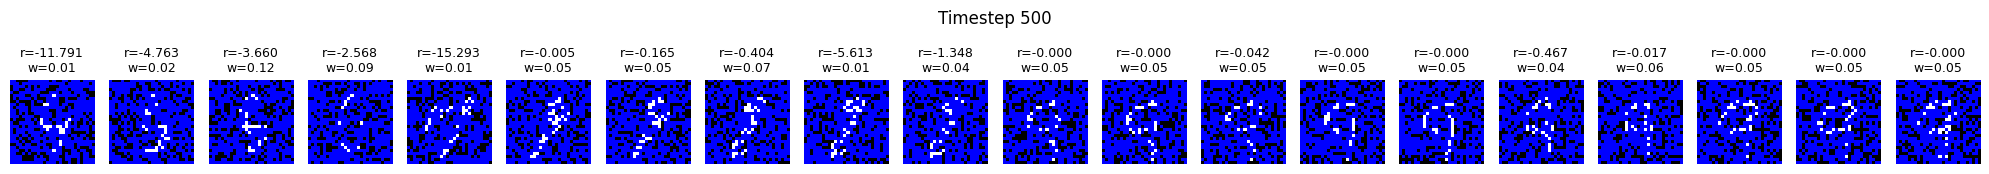

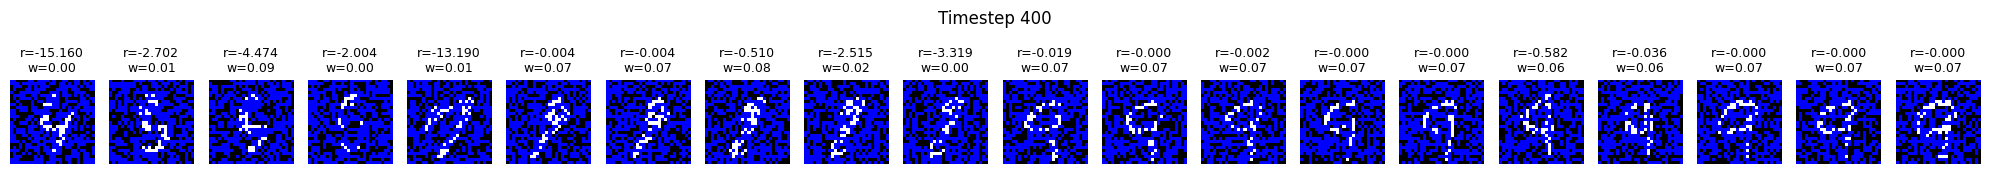

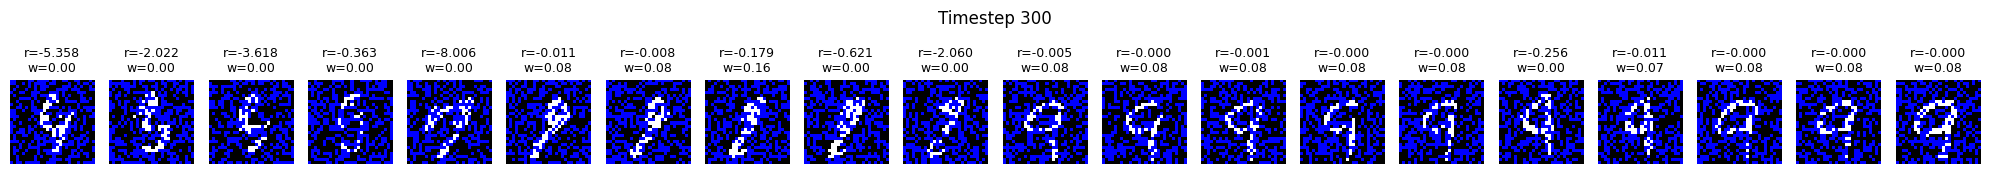

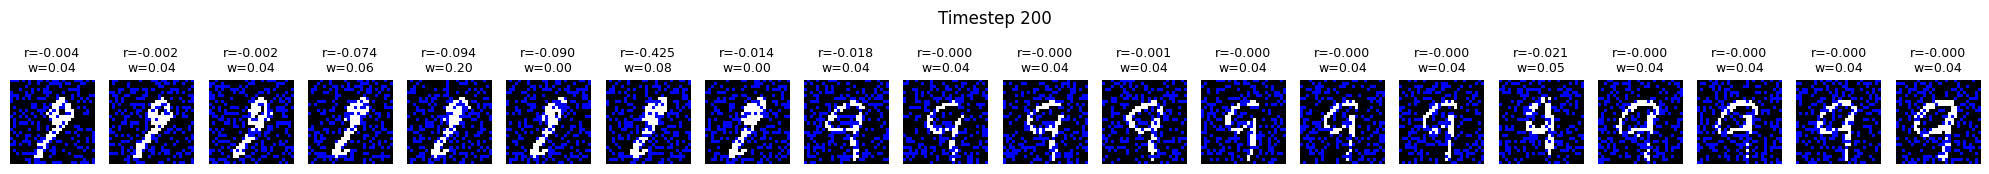

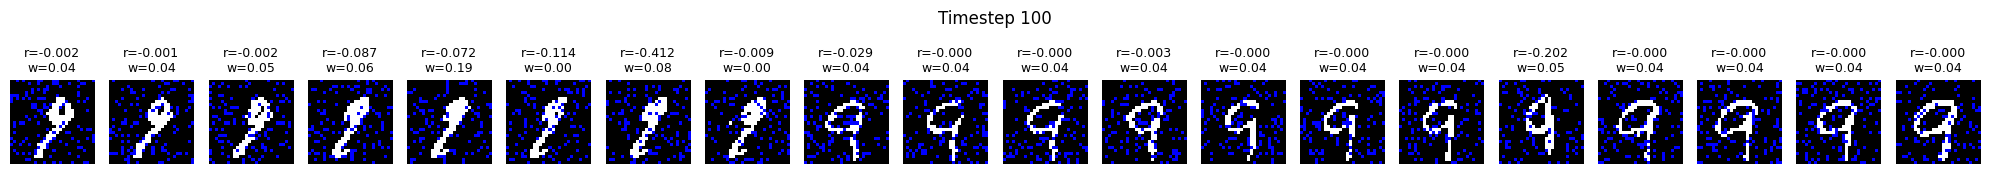

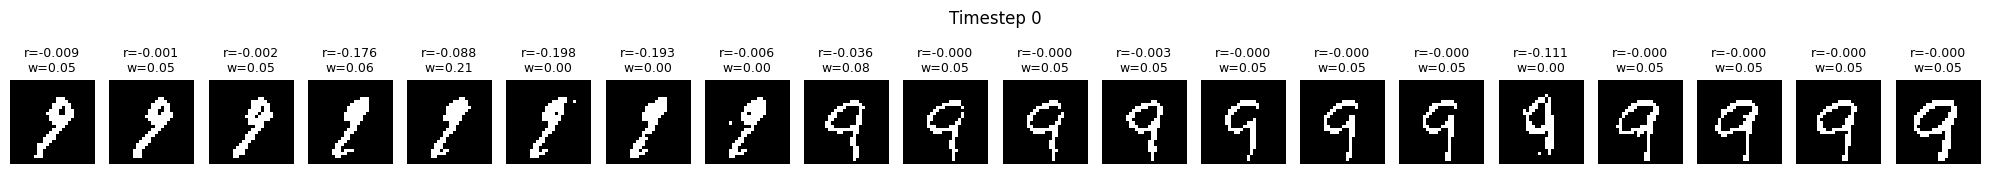

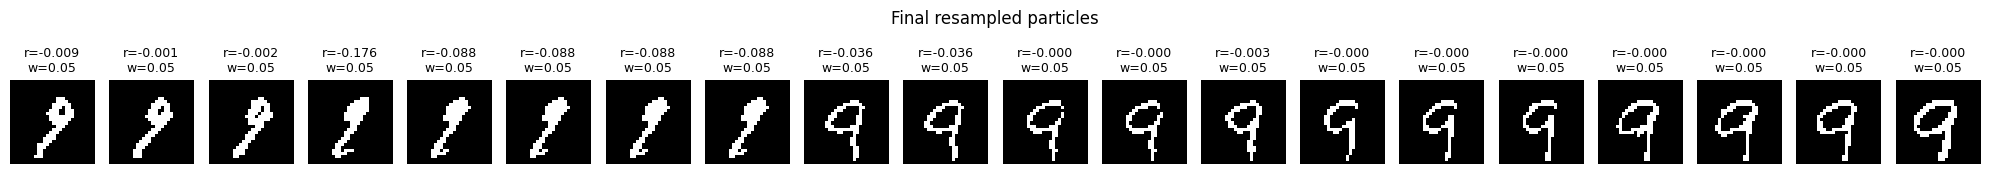

Final average reward: -0.0308
Final diversity score: 0.09164205155746503
Final uniqueness: 16


In [71]:
plot_smc_results_binarized_mnist(X_0, W_0, ess_trace, rewards_trace, particles_trace, log_weights_trace, resampling_trace, num_timesteps, vocab_size, num_categories, compute_rewards)